# Generate and visualize experiment-level simulated data

The goal of this notebook is to create a simulated compendium, keep track of the relationship between samples and experiments.

Then visualizing the placement of the original experiment and the simulated experiment

This figure can be found in the manuscript (Figure 4B)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import umap

import warnings
warnings.filterwarnings(action='ignore')

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

sys.path.append("../")
from functions import generate_data

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# User parameters
NN_architecture = 'NN_2500_30'
dataset_name = "Pseudomonas_analysis"
analysis_name = 'Pa_experiment_lvl_sim'
num_simulated_experiments = 6000
lst_num_partitions = [1]
use_pca = True
num_PCs = 10

In [3]:
# Input files

# base dir on repo
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../")) 

local_dir = local_dir = os.path.abspath(os.path.join(os.getcwd(), "../../..")) 

NN_dir = base_dir + "/models/" + NN_architecture

normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "train_set_normalized.pcl")

metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "sample_annotations.tsv")

In [4]:
# Output
experiment_simulated_file = os.path.join(
    base_dir,
    "results",
    "simulated_experiment_compendia.png")

### Load file with experiment ids

In [5]:
experiment_ids_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "experiment_ids.txt")

### Generate simulated data with experiment ids

In [6]:
# Generate simulated data
generate_data.simulate_compendium(experiment_ids_file, 
                                  num_simulated_experiments,
                                  normalized_data_file,
                                  NN_architecture,
                                  dataset_name,
                                  analysis_name
                                 )

Directory already exists: 
 /home/alexandra/Documents/Data/Batch_effects/simulated/Pa_experiment_lvl_sim


Normalized gene expression data contains 950 samples and 5549 genes
Return: simulated gene expression data containing 55983 samples and 5550 genes


### Load simulated gene expression data

In [7]:
# Simulated data file 
simulated_data_file = os.path.join(
    local_dir,
    "Data",
    "Batch_effects",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")
# Replace "simulated_data_labeled.txt.xz"

In [8]:
# Read in simulated data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0,
    index_col=0,
    sep='\t')

simulated_data.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
0,0.658,0.725,0.456,0.652,0.311,0.427,0.344,0.521,0.479,0.369,...,0.531,0.693,0.530,0.610,0.186,0.522,0.263,0.573,0.699,E-MEXP-2606_0
1,0.634,0.709,0.444,0.650,0.325,0.456,0.334,0.526,0.485,0.334,...,0.542,0.662,0.536,0.609,0.199,0.544,0.294,0.586,0.690,E-MEXP-2606_0
2,0.651,0.722,0.454,0.646,0.327,0.421,0.340,0.525,0.489,0.358,...,0.542,0.703,0.542,0.619,0.181,0.514,0.287,0.598,0.706,E-MEXP-2606_0
3,0.591,0.672,0.414,0.664,0.308,0.483,0.339,0.545,0.475,0.297,...,0.560,0.562,0.517,0.589,0.235,0.581,0.328,0.555,0.660,E-MEXP-2606_0
4,0.629,0.696,0.461,0.640,0.334,0.430,0.338,0.521,0.483,0.333,...,0.554,0.698,0.548,0.611,0.197,0.519,0.316,0.612,0.697,E-MEXP-2606_0


In [10]:
# Number of unique experiments in simulated dataset
ids = set([i.split("_")[0] for i in simulated_data['experiment_id']])
len(ids)     

107

### Add experiment ids to original gene expression data

In [12]:
# Read original input
normalized_data = pd.read_table(
        normalized_data_file,
        header=0,
        sep='\t',
        index_col=0).T

normalized_data.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


In [13]:
# Read in metadata
metadata = pd.read_table(
    metadata_file,
    header=0,
    index_col=0,
    sep='\t')

In [14]:
# Reset index to be referenced based on sample id
metadata = metadata.reset_index().set_index('ml_data_source')
metadata.head()

,experiment,sample_name,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
ml_data_source,,,,,,,,,,,,,,,,,
GSM1141730_PA01_ZnO_PZO_.CEL,E-GEOD-46947,GSM1141730 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
GSM1141729_PA01_none_PC_.CEL,E-GEOD-46947,GSM1141729 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
GSM1608059_Planktonic_1.CEL,E-GEOD-65882,GSM1608059 1,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608060_Planktonic_2.CEL,E-GEOD-65882,GSM1608060 1,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608061_Planktonic_3.CEL,E-GEOD-65882,GSM1608061 1,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN


In [15]:
# Remove sample ids that have duplicates
metadata = metadata.loc[~normalized_data.index.duplicated(keep=False)]

In [16]:
# Add experiment id to original gene expression data
sample_ids = list(normalized_data.index)
normalized_data_label = normalized_data.copy()
for sample_id in sample_ids:
    if sample_id in list(metadata.index):
        if metadata.loc[sample_id].ndim == 1:
            normalized_data_label.loc[sample_id,'experiment_id'] = metadata.loc[sample_id,'experiment']
        else:
            normalized_data_label.loc[sample_id,'experiment_id'] = 'NA'
    else:
        normalized_data_label.loc[sample_id,'experiment_id'] = 'NA'

normalized_data_label.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012,E-MEXP-2593
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374,NA
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099,E-MEXP-2867
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780,NA
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814,NA


## Visualize data

In [17]:
# Select example experiments
example_id_sim = "E-GEOD-51409_173"
example_id = "E-GEOD-51409"
#example_id_sim = "E-GEOD-52445_58"
#example_id = "E-GEOD-52445"
#example_id_sim = "E-GEOD-18594_2"
#example_id = "E-GEOD-18594"
#example_id_sim = "E-MEXP-2606_0"
#example_id = "E-MEXP-2606"

In [18]:
# Only label selected example labels for simulated data
simulated_data.loc[simulated_data['experiment_id'] == example_id_sim,'experiment_id'] = example_id

print(example_id in list(simulated_data['experiment_id']))

simulated_data.loc[simulated_data['experiment_id'] != example_id,'experiment_id'] = "not selected"

simulated_data.head()

True


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
0,0.658,0.725,0.456,0.652,0.311,0.427,0.344,0.521,0.479,0.369,...,0.531,0.693,0.530,0.610,0.186,0.522,0.263,0.573,0.699,not selected
1,0.634,0.709,0.444,0.650,0.325,0.456,0.334,0.526,0.485,0.334,...,0.542,0.662,0.536,0.609,0.199,0.544,0.294,0.586,0.690,not selected
2,0.651,0.722,0.454,0.646,0.327,0.421,0.340,0.525,0.489,0.358,...,0.542,0.703,0.542,0.619,0.181,0.514,0.287,0.598,0.706,not selected
3,0.591,0.672,0.414,0.664,0.308,0.483,0.339,0.545,0.475,0.297,...,0.560,0.562,0.517,0.589,0.235,0.581,0.328,0.555,0.660,not selected
4,0.629,0.696,0.461,0.640,0.334,0.430,0.338,0.521,0.483,0.333,...,0.554,0.698,0.548,0.611,0.197,0.519,0.316,0.612,0.697,not selected


In [19]:
example_id in list(simulated_data['experiment_id'])

True

In [20]:
# Only label selected example labels for original data
normalized_data_label.loc[normalized_data_label['experiment_id'] == example_id,'experiment_id'] = example_id
normalized_data_label.loc[normalized_data_label['experiment_id'] != example_id,'experiment_id'] = "not selected"

normalized_data_label.head()

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,experiment_id
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012,not selected
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374,not selected
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099,not selected
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780,not selected
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814,not selected


In [21]:
example_id in list(normalized_data_label['experiment_id'])

True

In [22]:
# UMAP embedding of original input data

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])
# Add label
input_data_UMAPencoded_df['experiment_id'] = normalized_data_label['experiment_id']

In [23]:
# UMAP embedding of simulated data

# Drop label column
simulated_data_numeric = simulated_data.drop(['experiment_id'], axis=1)

simulated_data_UMAPencoded = model.transform(simulated_data_numeric)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

# Add back label column
simulated_data_UMAPencoded_df['experiment_id'] = simulated_data['experiment_id']

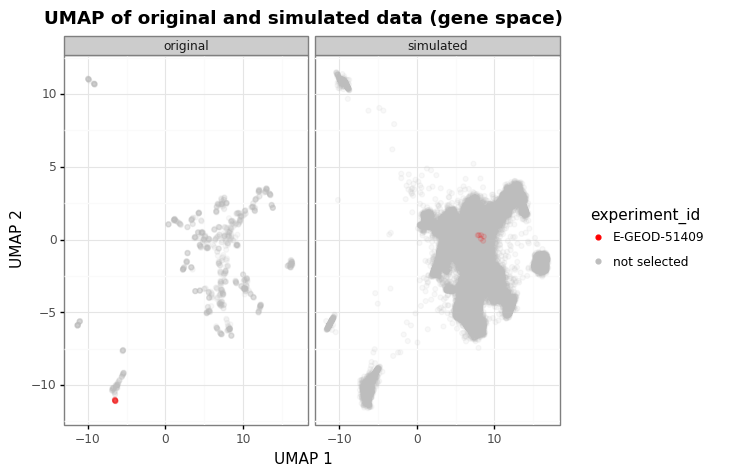

<ggplot: (8755534884188)>


In [24]:
# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot sequentially
#backgrd_data = combined_data_df[combined_data_df['experiment_id'] == 'Not selected']
#select_data = combined_data_df[combined_data_df['experiment_id'] != 'Not selected']

# Plot
fig = ggplot(combined_data_df, aes(x='1', y='2'))
fig += geom_point(aes(color='experiment_id'), alpha=0.1)
fig += facet_wrap('~dataset')
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'UMAP of original and simulated data (gene space)')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(weight='bold')
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
fig += scale_color_manual(['red', '#bdbdbd'])
fig += geom_point(data=combined_data_df[combined_data_df['experiment_id'] == example_id],
                  alpha=0.1, 
                  color='red')
    #+ xlim(-8,-5) \
    #+ ylim(-11.5,-10.5) \  

print(fig)
#ggsave(plot=fig, filename=experiment_simulated_file, dpi=500)